# Experiment with Images

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import glob

# Create a LIB of Images

First, we create a table to store information about each image.

Right now, it only contains the location of the local file.

As the collection grows, this table can be updated to include information such as period, artist, date, and title.

In [3]:
image_file_names = glob.glob("images/*.*")
LIB = pd.DataFrame({'path':image_file_names})
LIB.index.name = 'img_id'
LIB

,path
img_id,
0,images/maya-mural.jpg
1,images/Bonampak-Temple-of-the-Murals-musicians...
2,images/petzholdt-1832-cervara.jpeg
3,images/peake-1606-princess_elizabeth.jpeg
4,images/Jason-Parrish-Asdzaa-Lichii.jpg
5,images/boulogne-1613-staint_john.jpeg
6,images/snow-white-cartoon.jpg
7,images/dispicable-me-minions.jpeg


# Define Core Actions

We define a list of rbg columns for convenience.

In [47]:
rgb_cols = ['r','g','b']

## Get NumPy Array from File Name

This converts an image file into a plain text data structure that can processed using tools like NumPy and Pandas.

In [4]:
img_file = LIB.loc[4, 'path']
img_array = mpl.image.imread(img_file)
img_file, img_array.shape

('images/Jason-Parrish-Asdzaa-Lichii.jpg', (1129, 1136, 3))

## Display an Image Array

This displays an image from a NumPy array.

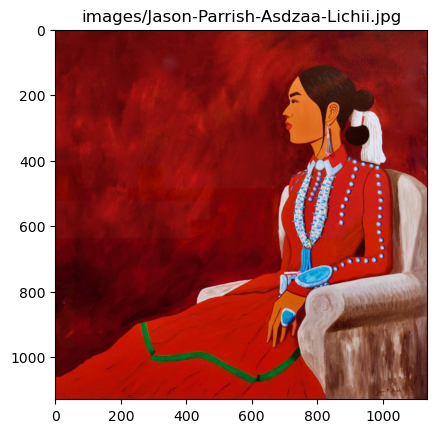

In [5]:
plt.imshow(img_array)
plt.title(img_file)
plt.show()

## Flatten Image Array

This flattens the 3D array into a 2D one. 

This is necessary to pass the data to other functions, such as the KMeans clusterer used below.

In [6]:
img_pixels = img_array.reshape(-1, img_array.shape[-1])
img_pixels.shape

(1282544, 3)

Here we grab the $x$ and $y$ coordinates for each pixel triple.

In [7]:
img_coords = np.array([(x, y) for x in range(img_array.shape[0]) for y in range(img_array.shape[1])])

In [8]:
img_coords.shape

(1282544, 2)

## Grab pixels from image

Here is a convenient function that does both of the above (without grabbing the coordinates).

In [9]:
def get_pixels_from_file(img_file):
    img_array = mpl.image.imread(img_file)
    pixels = img_array.reshape(-1, img_array.shape[-1])
    return pixels

In [10]:
img_pixels2 = get_pixels_from_file(LIB.loc[0].path)

In [11]:
img_pixels2.shape

(126869, 3)

## Extract Dominant Colors with K-Means

This function extracts the $k$ most dominant colors in the image.

Note that we can pass the pixels of an aggregated group of images, grouped by period, for example.

In [93]:
def get_main_colors(pixels, n_colors = 10):
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    color_freqs = pd.Series(kmeans.labels_).value_counts()
    return dominant_colors, color_freqs

In [94]:
img_dom_cols, img_cfreqs = get_main_colors(img_pixels)

In [14]:
def get_main_colors_df(pixels, n_colors = 10):
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    df = pd.DataFrame(dominant_colors, columns=rgb_cols)
    df['n'] = pd.Series(kmeans.labels_).value_counts()
    return df

In [15]:
DOMCOLS = get_main_colors_df(img_pixels)
DOMCOLS

,r,g,b,n
0,126,72,56,74011
1,202,193,198,64378
2,143,17,13,265800
3,75,9,10,155638
4,188,22,6,245521
5,172,134,124,56445
6,53,149,201,11616
7,221,109,32,28063
8,114,10,11,370079
9,10,94,27,10993


## Display Color Bar

Here is a function to convert a list of colors into a color bar.

In [16]:
def plot_colors(colors, title=None):
    df = pd.DataFrame(colors, columns=rgb_cols).sort_values(rgb_cols)
    w = len(colors)
    plt.figure(figsize=(w, 2))
    plt.imshow([df.values])
    plt.axis('off')
    plt.title(title)
    plt.show()

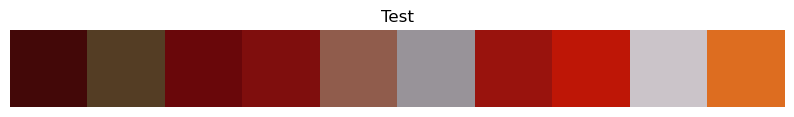

In [95]:
plot_colors(img_dom_cols, "Test")

## Display Bar Chart

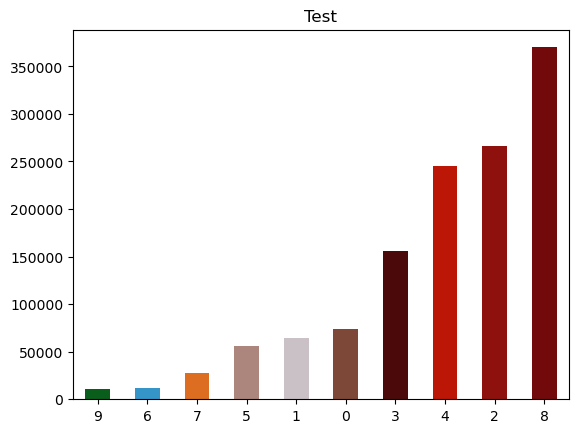

In [96]:
DOMCOLS = DOMCOLS.sort_values('n')
colors = DOMCOLS[rgb_cols].values / 255.0
DOMCOLS['n'].plot.bar(rot=0, color=colors)
plt.title("Test")
plt.show()

## Apply Functions to all the images in LIB

The `IMAGES` data frame will display all images in a collection or subcollection.

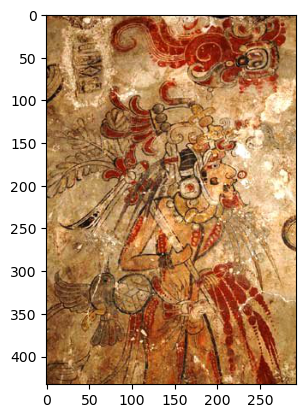

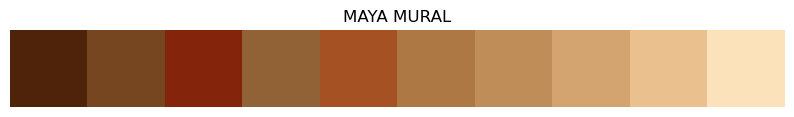

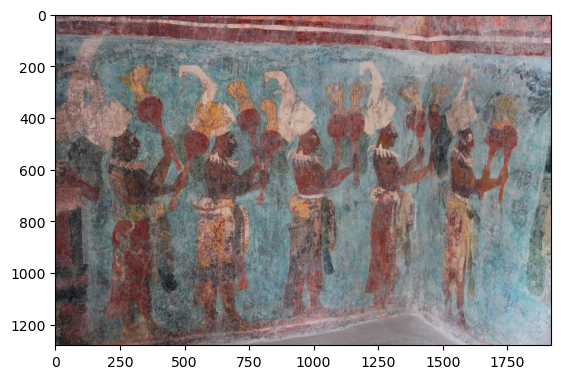

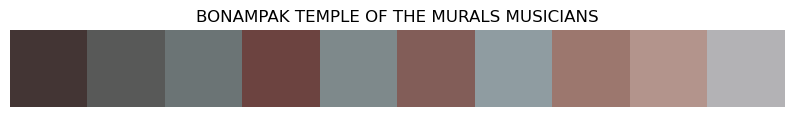

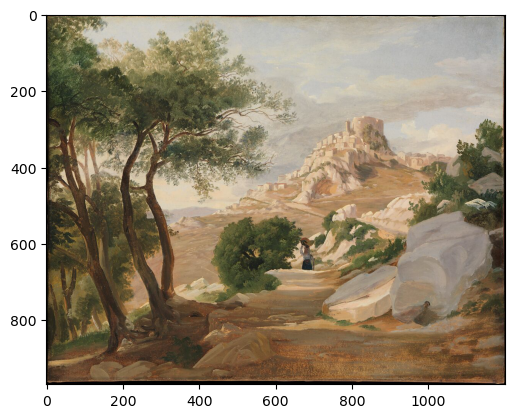

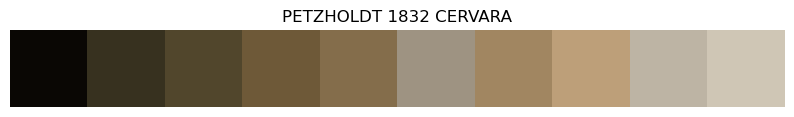

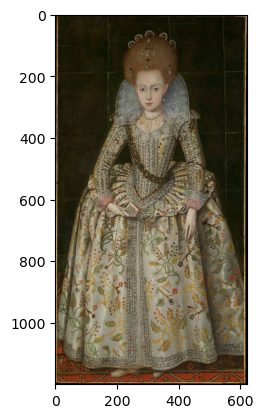

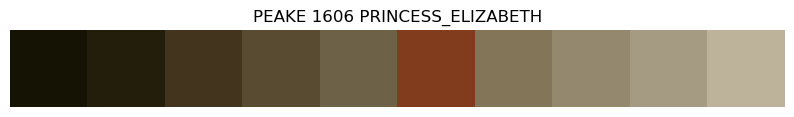

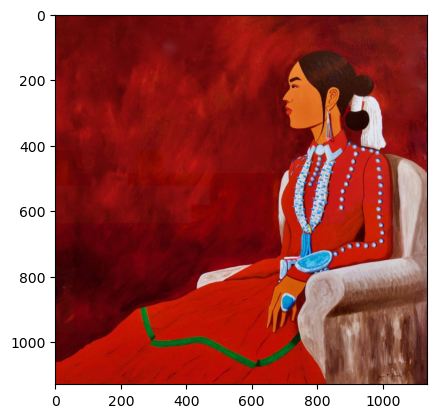

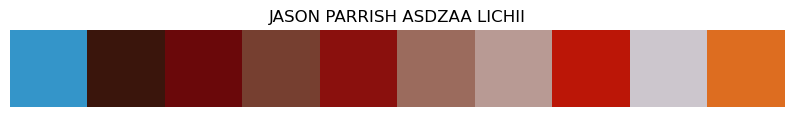

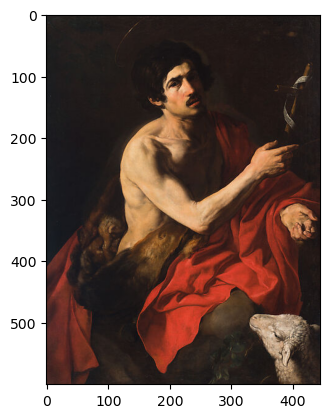

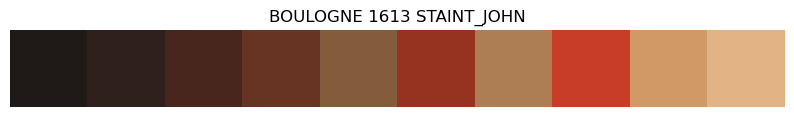

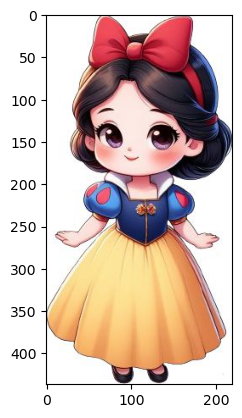

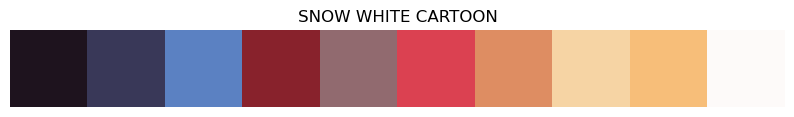

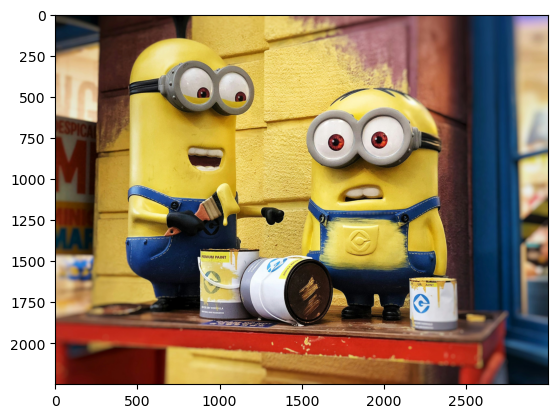

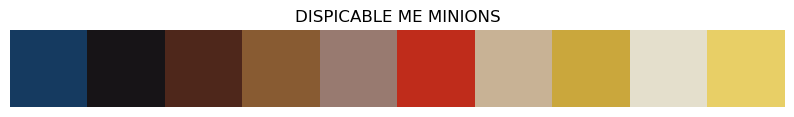

In [98]:
for idx, row in LIB.iterrows():
    
    # Get the file name on disk
    img_file = row.path

    # Read the file into a NumPy array
    img = mpl.image.imread(img_file)

    # Display the image
    plt.imshow(img)
    # plt.show()
    
    # Extract the 
    pixels = get_pixels_from_file(img_file)
    colors, _ = get_main_colors(pixels)
    title = row.path.split("/")[1].split(".")[0].replace("-", " ").upper()
    plot_colors(colors, title=title)

    plt.show()

# Consolidate Data for Bulk Actions

Here we combine all the data into single data frames in order to process them in bulk.

This will allow for things like getting the color profile of a group of images, say according to period or artist.

## Consolidate Images 

We create a single `IMAGES` data frame.

In [199]:
all_images = []
for idx, row in LIB.iterrows():
    img_file = row.path
    img_array = mpl.image.imread(img_file)
    X, Y, Z = img_array.shape
    df = pd.DataFrame(
        img_array.reshape(-1, 3), 
        index=pd.MultiIndex.from_product([range(X), range(Y)])
    )
    df.columns = rgb_cols
    df.index.names = ['x','y']
    df['rgb'] = (df.values / 255.).tolist()
    all_images.append(df)

In [200]:
IMAGES = pd.concat(all_images, keys=range(len(all_images)))
# Since the first index name is blank at this point, we prepend it 
IMAGES.index.names = ['img_id'] + IMAGES.index.names[1:] 
IMAGES.head()

r   g   b                                                rgb
img_id x y                                                                
0      0 0   86  27   0    [0.33725490196078434, 0.10588235294117647, 0.0]
         1  127  69  29  [0.4980392156862745, 0.27058823529411763, 0.11...
         2  149  94  55  [0.5843137254901961, 0.3686274509803922, 0.215...
         3  151  99  59  [0.592156862745098, 0.38823529411764707, 0.231...
         4  128  80  40  [0.5019607843137255, 0.3137254901960784, 0.156...

## Consolidate Dominant Colors

In [206]:
group_col = 'img_id'
COLORS = IMAGES.groupby(group_col)[rgb_cols].apply(get_main_colors_df)
COLORS.index.names = [group_col, 'color_id']
COLORS['rgb'] = (COLORS[['r', 'g', 'b']].values / 255).tolist()
COLORS

r    g    b        n  \
img_id color_id                           
0      0         168   85   37     8911   
       1         218  172  120    14207   
       2          82   37   11     7876   
       3         179  127   73    22053   
       4         252  232  194     3733   
...              ...  ...  ...      ...   
7      5         173  148  135   442302   
       6          88   45   30   801360   
       7         232  207  113  1112831   
       8          27   20   22   943413   
       9          95  101  110   251335   

                                                               rgb  
img_id color_id                                                     
0      0         [0.6588235294117647, 0.3333333333333333, 0.145...  
       1         [0.8549019607843137, 0.6745098039215687, 0.470...  
       2         [0.3215686274509804, 0.1450980392156863, 0.043...  
       3         [0.7019607843137254, 0.4980392156862745, 0.286...  
       4         [0.9882352941176471, 0.9098039215686274, 0.760...  
...                                                            ...  
7      5         [0.6784313725490196, 0.5803921568627451, 0.529...  
       6         [0.34509803921568627, 0.17647058823529413, 0.1...  
       7         [0.9098039215686274, 0.8117647058823529, 0.443...  
       8         [0.10588235294117647, 0.0784313725490196, 0.08...  
       9         [0.37254901960784315, 0.396078431372549, 0.431...  

[80 rows x 5 columns]

# Explore

## Create Matrices from `COLORS`

Matrix of counts.

In [245]:
M_n = COLORS.n.unstack()
M_n

color_id,0,1,2,3,4,5,6,7,8,9
img_id,,,,,,,,,,
0,8911,14207,7876,22053,3733,9981,16047,19752,10279,14030
1,274198,220267,223835,147776,282873,407844,129879,326063,198351,246514
2,134696,163393,122474,81623,154775,69575,117911,139978,22502,154673
3,17829,77889,79169,92551,77080,77223,32576,190395,76795,24893
4,245521,370079,11616,56445,64378,10993,155638,28063,265800,74011
5,10837,27143,11477,8513,98512,15369,12850,7196,54833,19670
6,10316,14259,32388,3571,9555,5549,5113,7780,3598,4011
7,685833,515145,709940,969499,318342,442302,801360,1112831,943413,251335


As probability.

In [210]:
M_p = (M_n.T / M_n.T.sum()).T

Matrix of `rgb` values.

In [250]:
M_rgb = COLORS.rgb.unstack()
M_rgb

color_id,0,1,2,3,4,5,6,7,8,9
img_id,,,,,,,,,,
0,"[0.6588235294117647, 0.3333333333333333, 0.145...","[0.8549019607843137, 0.6745098039215687, 0.470...","[0.3215686274509804, 0.1450980392156863, 0.043...","[0.7019607843137254, 0.4980392156862745, 0.286...","[0.9882352941176471, 0.9098039215686274, 0.760...","[0.5215686274509804, 0.14901960784313725, 0.04...","[0.596078431372549, 0.4117647058823529, 0.2313...","[0.7686274509803922, 0.5803921568627451, 0.372...","[0.9372549019607843, 0.7803921568627451, 0.588...","[0.4823529411764706, 0.29411764705882354, 0.14..."
1,"[0.5254901960784314, 0.3843137254901961, 0.360...","[0.6392156862745098, 0.4980392156862745, 0.458...","[0.34901960784313724, 0.3411764705882353, 0.33...","[0.7333333333333333, 0.6274509803921569, 0.6]","[0.4117647058823529, 0.4470588235294118, 0.450...","[0.4823529411764706, 0.5254901960784314, 0.533...","[0.6549019607843137, 0.7019607843137254, 0.725...","[0.5568627450980392, 0.6, 0.615686274509804]","[0.27058823529411763, 0.20784313725490197, 0.2...","[0.4392156862745098, 0.27450980392156865, 0.25..."
2,"[0.5215686274509804, 0.43137254901960786, 0.29...","[0.8156862745098039, 0.7803921568627451, 0.709...","[0.21568627450980393, 0.19215686274509805, 0.1...","[0.6274509803921569, 0.5803921568627451, 0.505...","[0.43137254901960786, 0.34901960784313724, 0.2...","[0.7647058823529411, 0.6549019607843137, 0.509...","[0.6431372549019608, 0.5333333333333333, 0.388...","[0.7333333333333333, 0.7098039215686275, 0.658...","[0.03529411764705882, 0.023529411764705882, 0....","[0.3137254901960784, 0.27450980392156865, 0.16..."
3,"[0.4980392156862745, 0.23529411764705882, 0.11...","[0.29411764705882354, 0.23529411764705882, 0.1...","[0.5568627450980392, 0.5215686274509804, 0.431...","[0.1607843137254902, 0.13333333333333333, 0.05...","[0.4666666666666667, 0.43137254901960786, 0.33...","[0.38823529411764707, 0.3411764705882353, 0.23...","[0.7411764705882353, 0.6980392156862745, 0.603...","[0.08627450980392157, 0.0784313725490196, 0.01...","[0.6431372549019608, 0.6039215686274509, 0.509...","[0.615686274509804, 0.49019607843137253, 0.278..."
4,"[0.7372549019607844, 0.08627450980392157, 0.02...","[0.4470588235294118, 0.0392156862745098, 0.043...","[0.20784313725490197, 0.5843137254901961, 0.78...","[0.6745098039215687, 0.5254901960784314, 0.486...","[0.792156862745098, 0.7568627450980392, 0.7764...","[0.0392156862745098, 0.3686274509803922, 0.105...","[0.29411764705882354, 0.03529411764705882, 0.0...","[0.8666666666666667, 0.42745098039215684, 0.12...","[0.5607843137254902, 0.06666666666666667, 0.05...","[0.49411764705882355, 0.2823529411764706, 0.21..."
5,"[0.7803921568627451, 0.23921568627450981, 0.15...","[0.23921568627450981, 0.13333333333333333, 0.1...","[0.7803921568627451, 0.5686274509803921, 0.376...","[0.592156862745098, 0.2, 0.12941176470588237]","[0.11764705882352941, 0.09411764705882353, 0.0...","[0.43137254901960786, 0.2196078431372549, 0.14...","[0.8784313725490196, 0.6901960784313725, 0.505...","[0.592156862745098, 0.4235294117647059, 0.2784...","[0.1568627450980392, 0.12156862745098039, 0.10...","[0.3215686274509804, 0.16862745098039217, 0.12..."
6,"[0.12549019607843137, 0.08235294117647059, 0.1...","[0.9803921568627451, 0.8274509803921568, 0.529...","[0.996078431372549, 0.996078431372549, 0.99215...","[0.5098039215686274, 0.47843137254901963, 0.59...","[0.8941176470588236, 0.5843137254901961, 0.372...","[0.43137254901960786, 0.20784313725490197, 0.2...","[0.8235294117647058, 0.25882352941176473, 0.31...","[0.9764705882352941, 0.8745098039215686, 0.847...","[0.17647058823529413, 0.23529411764705882, 0.4...","[0.8745098039215686, 0.6549019607843137, 0.650..."
7,"[0.06666666666666667, 0.20784313725490197, 0.3...","[0.8823529411764706, 0.8549019607843137, 0.792...","[0.615686274509804, 0.41568627450980394, 0.223...","[0.8235294117647058, 0.6941176470588235, 0.258...","[0.7450980392156863, 0.16862745098039217, 0.10...","[0.6784313725490196, 0.5803921568627451, 0.529..."

## Create Stacked Bar Plot from Matrices

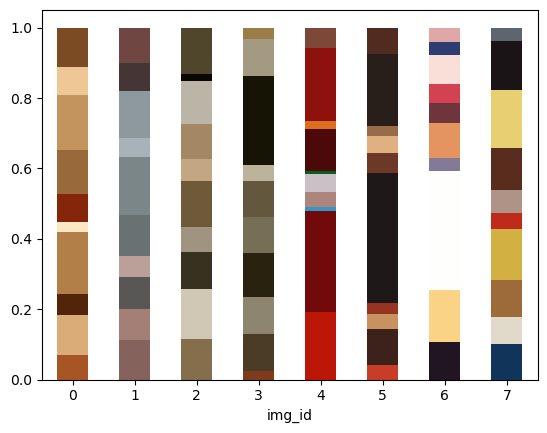

In [318]:
ax = M_p.plot.bar(stacked=True, legend=False, rot=0)

# Get all the bar patches
patches = ax.patches

# Calculate how many patches per image
n_images = M_p.shape[0]  # number of images (bars)
n_colors = M_p.shape[1]  # number of color segments

# Iterate through patches and apply colors
# There are n_images x n_colors patches (80)
for i, patch in enumerate(patches):

    # print(patch.xy[0], patch.xy[1])
    
    # Determine which image and which color this patch belongs to
    color_idx = i // n_images  # which color segment (0-9)
    img_idx = i % n_images     # which image (0-7)
    
    # Get the RGB color for this specific combination
    rgb = M_rgb.loc[img_idx, color_idx]
    
    # Set the color
    patch.set_facecolor(rgb)

## Explore Entropy

As entropy.

In [228]:
M_h = M_p * np.log2(1/M_p)

Add features to `LIB`.

In [259]:
LIB['n_pixels'] = M_n.T.sum()
LIB['color_entropy'] = M_h.T.sum()

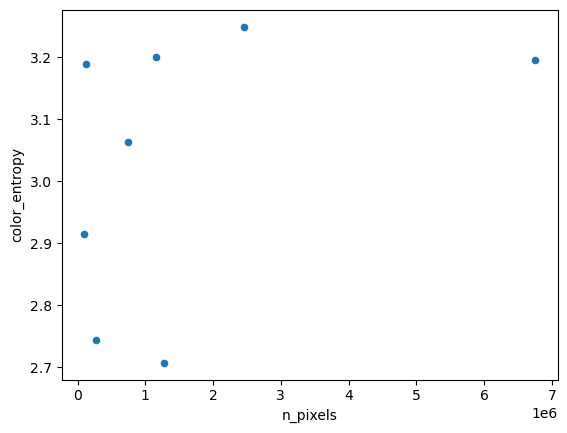

In [258]:
LIB.plot.scatter('n_pixels', 'color_entropy')
plt.show()